In [1]:
# =============================================================================
# MLB Batted Ball Outcome Model
# =============================================================================
# Predicts batted ball outcomes (out, single, double, triple, home_run) using
# exit velocity, launch angle, spray angle, and stadium effects.
#
# Data: Statcast batted ball events from 2024-2025 seasons
# Model: Gradient Boosting Classifier with scikit-learn pipeline
# =============================================================================

# ----- Setup: Clone repo and install dependencies -----
import os

# Clone the public repo (contains model and data)
if not os.path.exists('/content/baseball_game_simulator'):
    !git clone https://github.com/dgrifka/baseball_game_simulator.git /content/baseball_game_simulator

os.chdir('/content/baseball_game_simulator')
print(f"Working directory: {os.getcwd()}")

Cloning into '/content/baseball_game_simulator'...
remote: Enumerating objects: 1661, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 1661 (delta 409), reused 306 (delta 293), pack-reused 1186 (from 1)
Receiving objects: 100% (1661/1661), 45.63 MiB | 23.36 MiB/s, done.
Resolving deltas: 100% (1005/1005), done.
Working directory: /content/baseball_game_simulator


In [2]:
# ----- Imports -----
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
print("Imports complete")

Imports complete


In [3]:
# ----- Load Data -----
# Batted ball data stored as yearly parquet files
DATA_PATH = 'Data'
SEASONS = [2024, 2025]

# Load and combine batted ball data
batted_balls_list = []
for season in SEASONS:
    file_path = f'{DATA_PATH}/batted_balls/batted_balls_{season}.parquet'
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        batted_balls_list.append(df)
        print(f"Loaded {season}: {len(df):,} rows")
    else:
        print(f"File not found: {file_path}")

batted_balls = pd.concat(batted_balls_list, ignore_index=True)

# Load games data (contains venue_id for stadium effects)
games = pd.read_parquet(f'{DATA_PATH}/games/games.parquet')

print(f"\nTotal batted balls: {len(batted_balls):,}")
print(f"Total games: {len(games):,}")

Loaded 2024: 125,908 rows
Loaded 2025: 126,515 rows

Total batted balls: 252,423
Total games: 4,979


In [4]:
# ----- Merge batted balls with game info -----
# Join to get venue_id (more stable than venue_name which can change)
df = batted_balls.merge(
    games[['gamePk', 'venue_id', 'venue_name']],
    on='gamePk',
    how='left'
)

# Filter to rows with valid batted ball data
required_cols = ['hitData_launchSpeed', 'hitData_launchAngle',
                 'hitData_coordinates_coordX', 'hitData_coordinates_coordY']
df = df.dropna(subset=required_cols)

# Standardize event types: anything not a hit becomes 'out'
hit_types = ['single', 'double', 'triple', 'home_run']
df['eventType'] = df['eventType'].apply(lambda x: x if x in hit_types else 'out')

print(f"Rows after filtering: {len(df):,}")
print(f"\nEvent distribution:")
print(df['eventType'].value_counts())

Rows after filtering: 253,802

Event distribution:
eventType
out         172273
single       53032
double       15804
home_run     11352
triple        1341
Name: count, dtype: int64


In [5]:
# ----- Spray Angle Calculation -----
# MLB coordinate system: home plate at approximately (125.42, 199.02)
# X-axis: increases toward right field (from catcher's view)
# Y-axis: increases toward home plate (so outfield has lower Y values)

HOME_PLATE_X = 125.42
HOME_PLATE_Y = 199.02

def calculate_spray_angle(coord_x, coord_y):
    """
    Calculate spray angle in degrees from Statcast coordinates.

    Returns:
        0° = straight to center field
        Negative = toward left field
        Positive = toward right field
    """
    delta_x = coord_x - HOME_PLATE_X
    delta_y = HOME_PLATE_Y - coord_y  # Flip Y since it decreases into outfield

    # arctan2 gives angle in radians, convert to degrees
    angle_rad = np.arctan2(delta_x, delta_y)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

# Calculate raw spray angle
df['spray_angle'] = calculate_spray_angle(
    df['hitData_coordinates_coordX'],
    df['hitData_coordinates_coordY']
)

print("Spray angle calculated")
print(f"Range: {df['spray_angle'].min():.1f}° to {df['spray_angle'].max():.1f}°")
print(f"Mean: {df['spray_angle'].mean():.1f}°")

Spray angle calculated
Range: -179.9° to 180.0°
Mean: 1.1°


In [6]:
# ----- Handedness-Adjusted Spray Angle -----
# Normalize spray angle so that PULL direction is always negative for both L and R batters
# This creates a unified "pull tendency" metric
#
# Raw spray angle interpretation:
#   - Right-handed batter (R): pull = left field = negative angle ✓
#   - Left-handed batter (L): pull = right field = positive angle ✗
#
# Solution: Flip sign for left-handed batters

def adjust_spray_for_handedness(spray_angle, bat_side):
    """
    Adjust spray angle based on batter handedness.

    After adjustment:
        Negative = pulled (toward batter's pull side)
        Positive = opposite field
        ~0 = up the middle
    """
    if bat_side == 'L':
        return -spray_angle
    return spray_angle

df['spray_angle_adj'] = df.apply(
    lambda row: adjust_spray_for_handedness(row['spray_angle'], row['batSide_code']),
    axis=1
)

# Verify the adjustment worked
print("Adjusted spray angle by handedness:")
print(df.groupby('batSide_code')['spray_angle_adj'].agg(['mean', 'std', 'min', 'max']).round(1))

Adjusted spray angle by handedness:
              mean   std    min    max
batSide_code                          
L             -7.1  31.3 -180.0  179.7
R             -3.5  31.3 -179.9  179.9


In [7]:
# ----- Spray Angle Features -----
# Create categorical and derived features from spray angle

# 1. Spray direction categories
def categorize_spray(angle_adj):
    """Categorize adjusted spray angle into pull/center/oppo zones."""
    if angle_adj < -15:
        return 'pull'
    elif angle_adj > 15:
        return 'oppo'
    else:
        return 'center'

df['spray_direction'] = df['spray_angle_adj'].apply(categorize_spray)

# 2. Absolute spray angle (deviation from center, regardless of direction)
df['spray_angle_abs'] = df['spray_angle_adj'].abs()

# 3. Binary indicators
df['is_pulled'] = (df['spray_angle_adj'] < -15).astype(int)
df['is_opposite'] = (df['spray_angle_adj'] > 15).astype(int)

# Check distributions
print("Spray direction distribution:")
print(df['spray_direction'].value_counts(normalize=True).round(3))

print("\nSpray direction by event type:")
print(pd.crosstab(df['eventType'], df['spray_direction'], normalize='index').round(3))

Spray direction distribution:
spray_direction
pull      0.438
center    0.288
oppo      0.274
Name: proportion, dtype: float64

Spray direction by event type:
spray_direction  center   oppo   pull
eventType                            
double            0.200  0.271  0.529
home_run          0.203  0.115  0.683
out               0.286  0.288  0.427
single            0.339  0.263  0.398
triple            0.320  0.259  0.421


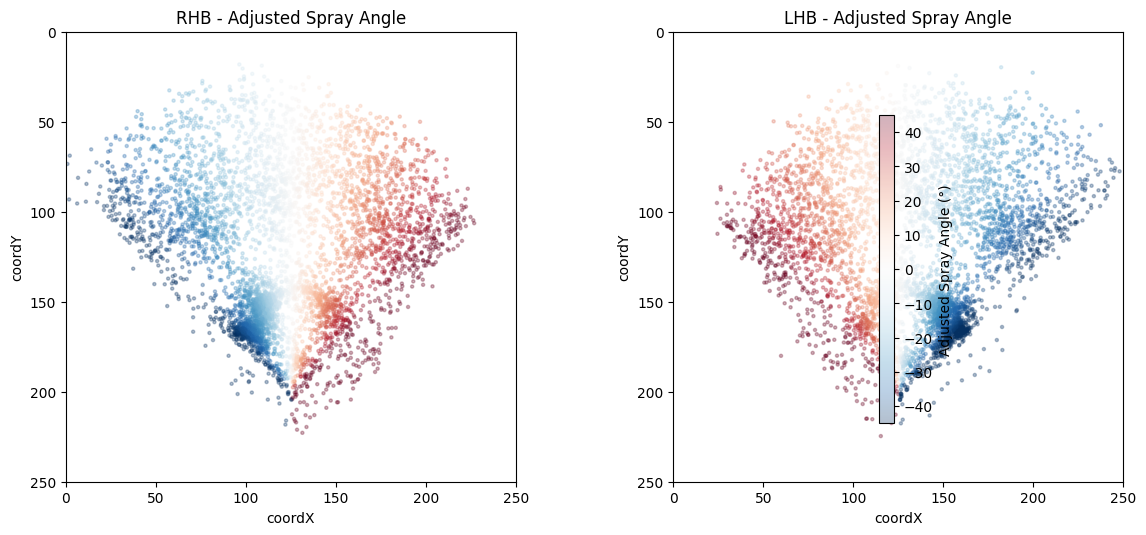

Blue = Pull side, Red = Opposite field
Both plots should show blue on the LEFT side (pull is normalized)


In [8]:
# ----- Validate Spray Angle Calculation -----
# Visual check: spray patterns should differ by handedness and match expected patterns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, bat_side in enumerate(['R', 'L']):
    ax = axes[idx]
    subset = df[df['batSide_code'] == bat_side].sample(min(5000, len(df)))

    scatter = ax.scatter(
        subset['hitData_coordinates_coordX'],
        subset['hitData_coordinates_coordY'],
        c=subset['spray_angle_adj'],
        cmap='RdBu_r',
        alpha=0.3,
        s=5,
        vmin=-45,
        vmax=45
    )

    ax.set_title(f'{bat_side}HB - Adjusted Spray Angle')
    ax.set_xlabel('coordX')
    ax.set_ylabel('coordY')
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    ax.invert_yaxis()  # Home plate at bottom
    ax.set_aspect('equal')

plt.colorbar(scatter, ax=axes, label='Adjusted Spray Angle (°)', shrink=0.8)
plt.tight_layout()
plt.show()

print("Blue = Pull side, Red = Opposite field")
print("Both plots should show blue on the LEFT side (pull is normalized)")

In [9]:
# ----- Core Batted Ball Features -----
# Features derived from exit velocity and launch angle

# 1. Convert launch angle to radians for calculations
df['angle_rad'] = np.radians(df['hitData_launchAngle'])

# 2. Distance proxy based on projectile motion physics
#    Captures the EV/LA relationship that determines carry
df['distance_proxy'] = df['hitData_launchSpeed'] * np.sin(2 * df['angle_rad'])

# 3. Launch angle categories (standard baseball classifications)
def categorize_launch_angle(angle):
    """Classify batted balls by launch angle."""
    if angle < 10:
        return 'ground_ball'
    elif angle < 25:
        return 'line_drive'
    elif angle < 50:
        return 'fly_ball'
    else:
        return 'popup'

df['launch_angle_category'] = df['hitData_launchAngle'].apply(categorize_launch_angle)

# 4. Barrel indicator (optimal HR zone: 95+ mph, 25-35 degrees)
df['is_barrel'] = (
    (df['hitData_launchSpeed'] >= 95) &
    (df['hitData_launchAngle'] >= 25) &
    (df['hitData_launchAngle'] <= 35)
).astype(int)

print("Launch angle category distribution:")
print(df['launch_angle_category'].value_counts(normalize=True).round(3))

print("\nBarrel rate:", f"{df['is_barrel'].mean():.1%}")

print("\nHome run rate by launch category:")
hr_rates = df.groupby('launch_angle_category')['eventType'].apply(
    lambda x: (x == 'home_run').mean()
).round(3)
print(hr_rates.sort_values(ascending=False))

Launch angle category distribution:
launch_angle_category
ground_ball    0.439
fly_ball       0.237
line_drive     0.221
popup          0.103
Name: proportion, dtype: float64

Barrel rate: 6.5%

Home run rate by launch category:
launch_angle_category
fly_ball       0.148
line_drive     0.044
ground_ball    0.000
popup          0.000
Name: eventType, dtype: float64


In [10]:
# ----- Interaction Features -----
# Capture relationships between spray angle, exit velocity, and launch angle

# 1. Pulled hard contact (high EV + pull side)
#    Important: hard-pulled balls have different outcomes than soft-pulled
df['pulled_hard'] = (
    (df['is_pulled'] == 1) &
    (df['hitData_launchSpeed'] >= 95)
).astype(int)

# 2. Opposite field power (unusual but valuable)
df['oppo_hard'] = (
    (df['is_opposite'] == 1) &
    (df['hitData_launchSpeed'] >= 95)
).astype(int)

# 3. Spray-EV interaction (continuous)
#    Captures how hard contact to pull side differs from soft contact
df['spray_ev_interaction'] = df['spray_angle_adj'] * df['hitData_launchSpeed']

# 4. Pulled ground ball (usually outs due to shifts, sometimes doubles down line)
df['pulled_ground_ball'] = (
    (df['is_pulled'] == 1) &
    (df['launch_angle_category'] == 'ground_ball')
).astype(int)

# 5. Opposite field line drive (often falls for hits)
df['oppo_line_drive'] = (
    (df['is_opposite'] == 1) &
    (df['launch_angle_category'] == 'line_drive')
).astype(int)

print("Interaction feature rates:")
print(f"  Pulled hard contact: {df['pulled_hard'].mean():.1%}")
print(f"  Opposite field hard: {df['oppo_hard'].mean():.1%}")
print(f"  Pulled ground balls: {df['pulled_ground_ball'].mean():.1%}")
print(f"  Oppo line drives:    {df['oppo_line_drive'].mean():.1%}")

# Check home run rates for key interactions
print("\nHome run rate by interaction:")
print(f"  Pulled + Barrel:     {df[df['is_pulled']==1].groupby('is_barrel')['eventType'].apply(lambda x: (x=='home_run').mean()).get(1, 0):.1%}")
print(f"  Oppo + Barrel:       {df[df['is_opposite']==1].groupby('is_barrel')['eventType'].apply(lambda x: (x=='home_run').mean()).get(1, 0):.1%}")

Interaction feature rates:
  Pulled hard contact: 18.9%
  Opposite field hard: 7.8%
  Pulled ground balls: 26.0%
  Oppo line drives:    5.6%

Home run rate by interaction:
  Pulled + Barrel:     79.8%
  Oppo + Barrel:       25.6%


In [11]:
# ----- Stadium Features -----
# Use venue_id instead of venue_name (more stable across seasons)

# Check venue coverage
print(f"Unique venues in data: {df['venue_id'].nunique()}")
print(f"Missing venue_id: {df['venue_id'].isna().sum()}")

# Handle any missing venue_id by filling with mode (most common stadium)
if df['venue_id'].isna().any():
    mode_venue = df['venue_id'].mode()[0]
    df['venue_id'] = df['venue_id'].fillna(mode_venue)
    print(f"Filled missing venues with mode: {mode_venue}")

# Convert to string for categorical encoding (sklearn prefers string categories)
df['venue_id'] = df['venue_id'].astype(int).astype(str)

# Show venue distribution (top 10)
print("\nTop 10 venues by batted balls:")
venue_counts = df.groupby(['venue_id', 'venue_name']).size().sort_values(ascending=False).head(10)
print(venue_counts)

Unique venues in data: 39
Missing venue_id: 0

Top 10 venues by batted balls:
venue_id  venue_name      
22        Dodger Stadium      9012
14        Rogers Centre       8901
19        Coors Field         8870
15        Chase Field         8752
7         Kauffman Stadium    8739
3313      Yankee Stadium      8658
3         Fenway Park         8646
2889      Busch Stadium       8628
3309      Nationals Park      8616
4169      loanDepot park      8614
dtype: int64


In [12]:
# ----- Data Quality Checks -----
# Identify potential outliers or data issues

print("Data quality summary:")
print("=" * 50)

# 1. Ground balls labeled as home runs (should be rare/zero)
ground_ball_hr = (
    (df['launch_angle_category'] == 'ground_ball') &
    (df['eventType'] == 'home_run')
).sum()
print(f"Ground balls labeled as HR: {ground_ball_hr} ({ground_ball_hr/len(df):.4%})")

# 2. Popups labeled as home runs (should be zero)
popup_hr = (
    (df['launch_angle_category'] == 'popup') &
    (df['eventType'] == 'home_run')
).sum()
print(f"Popups labeled as HR: {popup_hr}")

# 3. Extreme exit velocities
print(f"Exit velocity > 120 mph: {(df['hitData_launchSpeed'] > 120).sum()}")
print(f"Exit velocity < 20 mph: {(df['hitData_launchSpeed'] < 20).sum()}")

# 4. Spray angle extremes (should be rare - foul territory)
print(f"Spray angle > 50° or < -50°: {((df['spray_angle'].abs() > 50)).sum()}")

# Show the problematic ground ball HRs if any exist
if ground_ball_hr > 0:
    print("\nSample ground ball 'home runs' (likely data errors):")
    print(df[(df['launch_angle_category'] == 'ground_ball') &
             (df['eventType'] == 'home_run')][
        ['hitData_launchSpeed', 'hitData_launchAngle', 'eventType', 'spray_angle']
    ].head())

Data quality summary:
Ground balls labeled as HR: 0 (0.0000%)
Popups labeled as HR: 1
Exit velocity > 120 mph: 6
Exit velocity < 20 mph: 177
Spray angle > 50° or < -50°: 9496


In [13]:
# ----- Prepare Final Feature Set -----
# Select and organize features for modeling

# Target variable
df['eventType_numeric'] = df['eventType'].map({
    'out': 0,
    'single': 1,
    'double': 2,
    'triple': 3,
    'home_run': 4
})

# Define feature groups
NUMERIC_FEATURES = [
    'hitData_launchSpeed',      # Exit velocity
    'hitData_launchAngle',      # Launch angle
    'distance_proxy',           # Physics-based distance estimate
    'spray_angle_adj',          # Handedness-adjusted spray angle
    'spray_angle_abs',          # Absolute spray deviation from center
    'is_barrel',                # Barrel zone indicator
    'is_pulled',                # Pull side indicator
    'is_opposite',              # Opposite field indicator
    'pulled_hard',              # Pull + hard contact interaction
    'oppo_hard',                # Oppo + hard contact interaction
    'spray_ev_interaction',     # Spray × EV interaction
    'pulled_ground_ball',       # Pull + ground ball interaction
    'oppo_line_drive',          # Oppo + line drive interaction
]

CATEGORICAL_FEATURES = [
    'launch_angle_category',    # Ground ball, line drive, fly ball, popup
    'spray_direction',          # Pull, center, oppo
    'venue_id',                 # Stadium effects
]

# Create feature matrix
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES].copy()
y = df['eventType_numeric'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumeric features ({len(NUMERIC_FEATURES)}): {NUMERIC_FEATURES}")
print(f"\nCategorical features ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")

# Check for any remaining nulls
null_counts = X.isnull().sum()
if null_counts.any():
    print(f"\nWarning - Null values found:")
    print(null_counts[null_counts > 0])
else:
    print("\nNo null values in feature matrix ✓")

Feature matrix shape: (253802, 16)
Target shape: (253802,)

Numeric features (13): ['hitData_launchSpeed', 'hitData_launchAngle', 'distance_proxy', 'spray_angle_adj', 'spray_angle_abs', 'is_barrel', 'is_pulled', 'is_opposite', 'pulled_hard', 'oppo_hard', 'spray_ev_interaction', 'pulled_ground_ball', 'oppo_line_drive']

Categorical features (3): ['launch_angle_category', 'spray_direction', 'venue_id']

No null values in feature matrix ✓


Highly correlated feature pairs (|r| > 0.7):
  spray_angle_adj <-> spray_ev_interaction: r = 0.975
  hitData_launchAngle <-> distance_proxy: r = 0.842
  is_pulled <-> spray_ev_interaction: r = -0.794
  is_opposite <-> spray_ev_interaction: r = 0.777
  spray_angle_adj <-> is_pulled: r = -0.775
  spray_angle_adj <-> is_opposite: r = 0.771


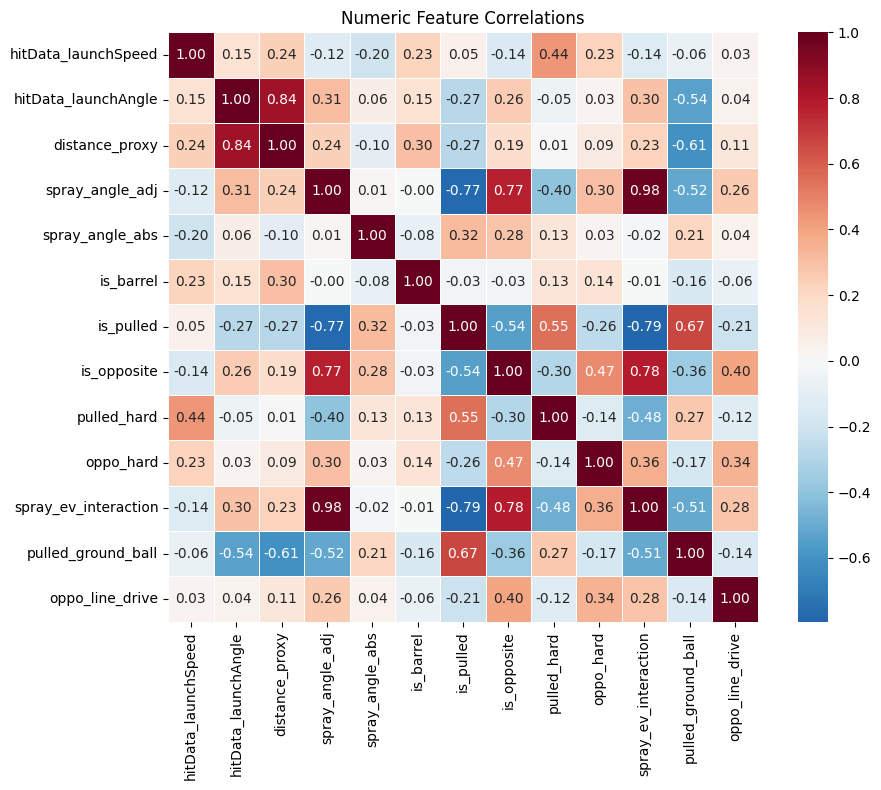

In [14]:
# ----- Feature Correlations -----
# Check for multicollinearity in numeric features

corr_matrix = X[NUMERIC_FEATURES].corr()

# Find highly correlated pairs (|r| > 0.7)
high_corr_pairs = []
for i in range(len(NUMERIC_FEATURES)):
    for j in range(i+1, len(NUMERIC_FEATURES)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((NUMERIC_FEATURES[i], NUMERIC_FEATURES[j], corr_val))

print("Highly correlated feature pairs (|r| > 0.7):")
if high_corr_pairs:
    for f1, f2, r in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
        print(f"  {f1} <-> {f2}: r = {r:.3f}")
else:
    print("  None found")

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Numeric Feature Correlations')
plt.tight_layout()
plt.show()

In [15]:
# ----- Stadium Mapping: Rays 2025 Edge Case -----
# The Rays played at George M. Steinbrenner Field in 2025 after Hurricane Milton
# damaged Tropicana Field. Steinbrenner has similar dimensions to Yankee Stadium.
# For 2026+, Rays return to Tropicana Field.
#
# Solution: Map Steinbrenner Field games to Yankee Stadium's venue_id
# This preserves Tropicana Field effects from 2024 data.

# Find the venue IDs
print("Checking stadium IDs:")
stadium_lookup = df.groupby(['venue_id', 'venue_name']).size().reset_index(name='count')

# Find Steinbrenner Field
steinbrenner = stadium_lookup[stadium_lookup['venue_name'].str.contains('Steinbrenner', case=False, na=False)]
print(f"\nSteinbrenner Field:\n{steinbrenner}")

# Find Yankee Stadium
yankee = stadium_lookup[stadium_lookup['venue_name'].str.contains('Yankee', case=False, na=False)]
print(f"\nYankee Stadium:\n{yankee}")

# Find Tropicana Field
tropicana = stadium_lookup[stadium_lookup['venue_name'].str.contains('Tropicana', case=False, na=False)]
print(f"\nTropicana Field:\n{tropicana}")

Checking stadium IDs:

Steinbrenner Field:
   venue_id                    venue_name  count
14     2523  George M. Steinbrenner Field   4088

Yankee Stadium:
   venue_id      venue_name  count
27     3313  Yankee Stadium   8658

Tropicana Field:
  venue_id       venue_name  count
2       12  Tropicana Field   3999


In [16]:
# ----- Apply Stadium Mapping -----
# Map Steinbrenner Field → Yankee Stadium

YANKEE_STADIUM_ID = '3313'  # From lookup above

# Get Steinbrenner Field venue_id (update if different from lookup)
steinbrenner_ids = stadium_lookup[
    stadium_lookup['venue_name'].str.contains('Steinbrenner', case=False, na=False)
]['venue_id'].tolist()

if steinbrenner_ids:
    for stein_id in steinbrenner_ids:
        count_before = (df['venue_id'] == stein_id).sum()

        # Update in both df and X
        df.loc[df['venue_id'] == stein_id, 'venue_id'] = YANKEE_STADIUM_ID
        X.loc[X['venue_id'] == stein_id, 'venue_id'] = YANKEE_STADIUM_ID

        print(f"Mapped venue_id {stein_id} (Steinbrenner) → {YANKEE_STADIUM_ID} (Yankee Stadium)")
        print(f"  Rows affected: {count_before:,}")
else:
    print("No Steinbrenner Field games found in data")

# Verify Tropicana Field still has 2024 data
tropicana_id = stadium_lookup[
    stadium_lookup['venue_name'].str.contains('Tropicana', case=False, na=False)
]['venue_id'].values

if len(tropicana_id) > 0:
    trop_count = (df['venue_id'] == tropicana_id[0]).sum()
    print(f"\nTropicana Field (venue_id {tropicana_id[0]}): {trop_count:,} batted balls (2024 data)")
else:
    print("\nWarning: No Tropicana Field data found")

# Final venue count
print(f"\nFinal unique venues: {df['venue_id'].nunique()}")

Mapped venue_id 2523 (Steinbrenner) → 3313 (Yankee Stadium)
  Rows affected: 4,088

Tropicana Field (venue_id 12): 3,999 batted balls (2024 data)

Final unique venues: 38


In [17]:
# ----- Train/Test Split -----
# Stratified split to maintain class proportions (important for rare classes like triples)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

print("\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

Training set: 203,041 samples
Test set: 50,761 samples

Class distribution in test set:
eventType_numeric
0    34455
1    10607
2     3161
3      268
4     2270
Name: count, dtype: int64


In [18]:
# ----- Preprocessing Pipeline -----
# StandardScaler for numeric features, OneHotEncoder for categorical

preprocessor = make_column_transformer(
    (StandardScaler(), NUMERIC_FEATURES),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES),
    remainder='drop'
)

print("Preprocessor configured:")
print(f"  Numeric features: {len(NUMERIC_FEATURES)} → StandardScaler")
print(f"  Categorical features: {len(CATEGORICAL_FEATURES)} → OneHotEncoder")

Preprocessor configured:
  Numeric features: 13 → StandardScaler
  Categorical features: 3 → OneHotEncoder


In [19]:
# ----- Model 1: Gradient Boosting Classifier -----
# This is the current production model architecture

gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.15,
        min_samples_split=50,
        min_samples_leaf=20,
        random_state=42
    ))
])

print("Training Gradient Boosting Classifier...")
%time gbc_pipeline.fit(X_train, y_train)

# Predictions
y_pred_gbc = gbc_pipeline.predict(X_test)
y_pred_proba_gbc = gbc_pipeline.predict_proba(X_test)

# Metrics
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
logloss_gbc = log_loss(y_test, y_pred_proba_gbc)

print(f"\nGradient Boosting Results:")
print(f"  Accuracy: {accuracy_gbc:.4f}")
print(f"  Log Loss: {logloss_gbc:.4f}")

Training Gradient Boosting Classifier...
CPU times: user 14min 18s, sys: 86.6 ms, total: 14min 19s
Wall time: 14min 19s

Gradient Boosting Results:
  Accuracy: 0.8204
  Log Loss: 0.4506


In [20]:
# ----- Model 2: HistGradient Boosting Classifier -----
# Faster training, native categorical support, handles missing values
# Note: Requires manual preprocessing since it handles categoricals differently

from sklearn.preprocessing import OrdinalEncoder

# HistGBC needs ordinal encoding for categoricals (not one-hot)
hist_preprocessor = make_column_transformer(
    (StandardScaler(), NUMERIC_FEATURES),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), CATEGORICAL_FEATURES),
    remainder='drop'
)

histgbc_pipeline = Pipeline([
    ('preprocessor', hist_preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=6,
        learning_rate=0.15,
        min_samples_leaf=20,
        categorical_features=list(range(len(NUMERIC_FEATURES), len(NUMERIC_FEATURES) + len(CATEGORICAL_FEATURES))),
        random_state=42
    ))
])

print("Training HistGradient Boosting Classifier...")
%time histgbc_pipeline.fit(X_train, y_train)

# Predictions
y_pred_histgbc = histgbc_pipeline.predict(X_test)
y_pred_proba_histgbc = histgbc_pipeline.predict_proba(X_test)

# Metrics
accuracy_histgbc = accuracy_score(y_test, y_pred_histgbc)
logloss_histgbc = log_loss(y_test, y_pred_proba_histgbc)

print(f"\nHistGradient Boosting Results:")
print(f"  Accuracy: {accuracy_histgbc:.4f}")
print(f"  Log Loss: {logloss_histgbc:.4f}")

Training HistGradient Boosting Classifier...
CPU times: user 10.2 s, sys: 48 ms, total: 10.2 s
Wall time: 2.78 s

HistGradient Boosting Results:
  Accuracy: 0.8196
  Log Loss: 0.4601


In [21]:
# ----- Model Comparison -----
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

results = pd.DataFrame({
    'Model': ['GradientBoosting', 'HistGradientBoosting'],
    'Accuracy': [accuracy_gbc, accuracy_histgbc],
    'Log Loss': [logloss_gbc, logloss_histgbc]
})

print(results.to_string(index=False))

# Determine best model
best_model_name = results.loc[results['Log Loss'].idxmin(), 'Model']
print(f"\nBest model (lowest log loss): {best_model_name}")

# Use best model for detailed evaluation
if best_model_name == 'GradientBoosting':
    best_pipeline = gbc_pipeline
    y_pred_best = y_pred_gbc
    y_pred_proba_best = y_pred_proba_gbc
else:
    best_pipeline = histgbc_pipeline
    y_pred_best = y_pred_histgbc
    y_pred_proba_best = y_pred_proba_histgbc

MODEL COMPARISON
               Model  Accuracy  Log Loss
    GradientBoosting  0.820374  0.450591
HistGradientBoosting  0.819645  0.460087

Best model (lowest log loss): GradientBoosting


In [22]:
# ----- Detailed Classification Report -----
target_names = ['out', 'single', 'double', 'triple', 'home_run']

print(f"\nClassification Report ({best_model_name}):")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=target_names))


Classification Report (GradientBoosting):
              precision    recall  f1-score   support

         out       0.86      0.93      0.89     34455
      single       0.73      0.60      0.66     10607
      double       0.64      0.48      0.55      3161
      triple       0.12      0.01      0.02       268
    home_run       0.78      0.81      0.80      2270

    accuracy                           0.82     50761
   macro avg       0.63      0.57      0.58     50761
weighted avg       0.81      0.82      0.81     50761



In [23]:
# ----- Edge Case Validation -----
# Verify model doesn't predict HRs for ground balls

test_df = X_test.copy()
test_df['y_true'] = y_test.values
test_df['y_pred'] = y_pred_best
test_df['hr_prob'] = y_pred_proba_best[:, 4]  # Home run probability

# Ground ball analysis
ground_balls = test_df[test_df['launch_angle_category'] == 'ground_ball']

print("Ground Ball Analysis:")
print(f"  Total ground balls in test set: {len(ground_balls):,}")
print(f"  Predicted as home runs: {(ground_balls['y_pred'] == 4).sum()}")
print(f"  Avg HR probability: {ground_balls['hr_prob'].mean():.6f}")
print(f"  Max HR probability: {ground_balls['hr_prob'].max():.6f}")

# Popup analysis
popups = test_df[test_df['launch_angle_category'] == 'popup']
print(f"\nPopup Analysis:")
print(f"  Total popups in test set: {len(popups):,}")
print(f"  Predicted as home runs: {(popups['y_pred'] == 4).sum()}")
print(f"  Max HR probability: {popups['hr_prob'].max():.6f}")

Ground Ball Analysis:
  Total ground balls in test set: 22,418
  Predicted as home runs: 0
  Avg HR probability: 0.000181
  Max HR probability: 0.204275

Popup Analysis:
  Total popups in test set: 5,251
  Predicted as home runs: 0
  Max HR probability: 0.046482


In [24]:
# ----- Feature Importance Analysis -----
# Extract feature names after preprocessing

# Get feature names from the preprocessor
feature_names = gbc_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importance = gbc_pipeline.named_steps['classifier'].feature_importances_

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
print("=" * 50)
print(importance_df.head(20).to_string(index=False))

# Summarize by feature group
print("\n\nImportance by Feature Group:")
print("=" * 50)

# Core features
core_features = ['hitData_launchSpeed', 'hitData_launchAngle', 'distance_proxy']
core_imp = importance_df[importance_df['feature'].str.contains('|'.join(core_features))]['importance'].sum()

# Spray angle features
spray_features = ['spray_angle', 'is_pulled', 'is_opposite', 'pulled_hard', 'oppo_hard',
                  'spray_ev_interaction', 'pulled_ground_ball', 'oppo_line_drive', 'spray_direction']
spray_imp = importance_df[importance_df['feature'].str.contains('|'.join(spray_features))]['importance'].sum()

# Barrel feature
barrel_imp = importance_df[importance_df['feature'].str.contains('is_barrel')]['importance'].sum()

# Launch angle category
la_cat_imp = importance_df[importance_df['feature'].str.contains('launch_angle_category')]['importance'].sum()

# Venue features
venue_imp = importance_df[importance_df['feature'].str.contains('venue_id')]['importance'].sum()

print(f"  Core (EV, LA, distance):    {core_imp:.1%}")
print(f"  Spray angle features:       {spray_imp:.1%}")
print(f"  Barrel indicator:           {barrel_imp:.1%}")
print(f"  Launch angle category:      {la_cat_imp:.1%}")
print(f"  Venue effects:              {venue_imp:.1%}")

Top 20 Most Important Features:
                                        feature  importance
                 standardscaler__distance_proxy    0.273745
            standardscaler__hitData_launchSpeed    0.179237
onehotencoder__launch_angle_category_line_drive    0.138648
            standardscaler__hitData_launchAngle    0.123611
                standardscaler__spray_angle_abs    0.087764
           standardscaler__spray_ev_interaction    0.068762
                standardscaler__spray_angle_adj    0.056556
                      standardscaler__is_barrel    0.045879
             standardscaler__pulled_ground_ball    0.008561
                    standardscaler__pulled_hard    0.005373
  onehotencoder__launch_angle_category_fly_ball    0.002273
                      standardscaler__oppo_hard    0.000754
                      onehotencoder__venue_id_3    0.000649
                     onehotencoder__venue_id_19    0.000630
                   onehotencoder__venue_id_3313    0.000587
        

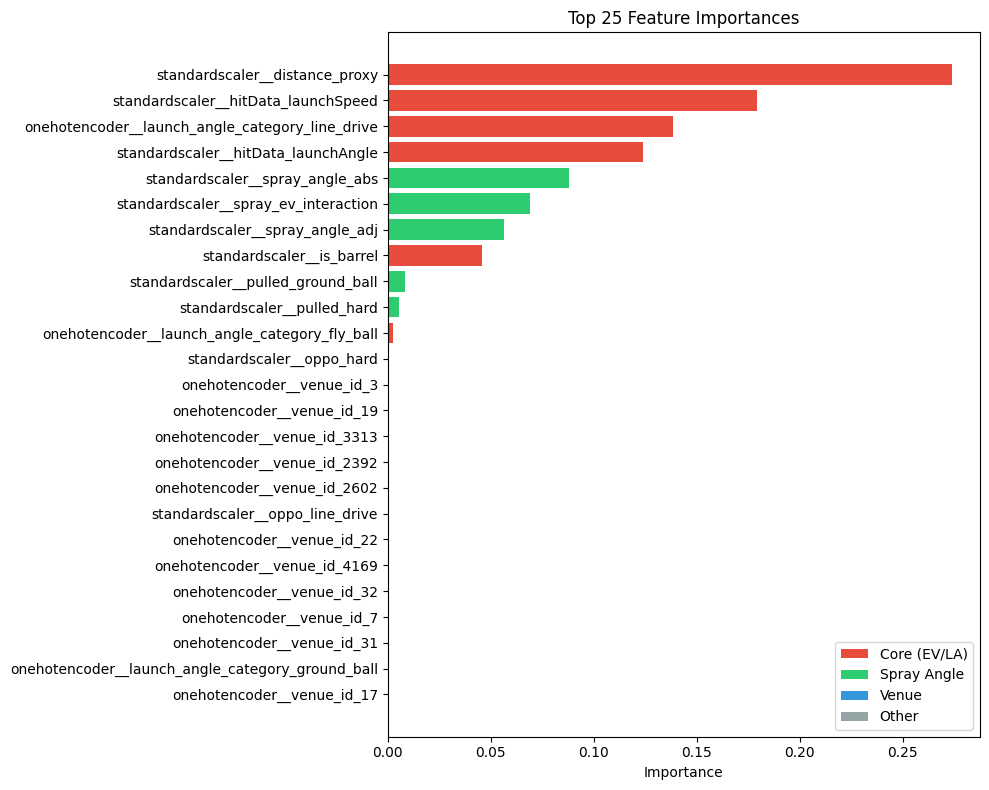

In [25]:
# ----- Feature Importance Plot -----
# Show top 25 features

top_n = 25
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

# Color by feature type
colors = []
for feat in top_features['feature']:
    if 'spray' in feat.lower() or 'pull' in feat.lower() or 'oppo' in feat.lower():
        colors.append('#2ecc71')  # Green for spray-related
    elif 'venue' in feat.lower():
        colors.append('#3498db')  # Blue for venue
    elif 'launch' in feat.lower() or 'barrel' in feat.lower() or 'distance' in feat.lower():
        colors.append('#e74c3c')  # Red for core batted ball
    else:
        colors.append('#95a5a6')  # Gray for other

bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importances')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Core (EV/LA)'),
    Patch(facecolor='#2ecc71', label='Spray Angle'),
    Patch(facecolor='#3498db', label='Venue'),
    Patch(facecolor='#95a5a6', label='Other')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

In [26]:
# ----- Save Model Pipeline -----
import joblib

MODEL_DIR = 'Model'
MODEL_FILENAME = 'batted_ball_model.pkl'
MODEL_PATH = f'{MODEL_DIR}/{MODEL_FILENAME}'

# Ensure directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Save with joblib (more efficient than pickle for sklearn)
joblib.dump(gbc_pipeline, MODEL_PATH)

# Check file size (GitHub limit is 100MB, recommend < 50MB)
file_size_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)
print(f"Model saved to: {MODEL_PATH}")
print(f"File size: {file_size_mb:.2f} MB")

if file_size_mb > 100:
    print("⚠️  WARNING: File exceeds GitHub 100MB limit!")
elif file_size_mb > 50:
    print("⚠️  WARNING: File exceeds 50MB - consider Git LFS")
else:
    print("✓ File size OK for GitHub")

Model saved to: Model/batted_ball_model.pkl
File size: 2.90 MB
✓ File size OK for GitHub


In [30]:
# ----- Save Model Metadata -----
# Store model info for documentation and reproducibility

import json
from datetime import datetime

metadata = {
    'model_name': 'MLB Batted Ball Outcome Classifier',
    'model_type': 'GradientBoostingClassifier',
    'created_date': datetime.now().strftime('%Y-%m-%d'),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'seasons': SEASONS,
    'accuracy': round(accuracy_gbc, 4),
    'log_loss': round(logloss_gbc, 4),
    'features': {
        'numeric': NUMERIC_FEATURES,
        'categorical': CATEGORICAL_FEATURES
    },
    'classes': {
        '0': 'out',
        '1': 'single',
        '2': 'double',
        '3': 'triple',
        '4': 'home_run'
    },
    'hyperparameters': {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.15,
        'min_samples_split': 50,
        'min_samples_leaf': 20
    },
    'notes': [
        'Spray angle adjusted for batter handedness (negative = pull side)',
        'Steinbrenner Field (Rays 2025) mapped to Yankee Stadium venue_id',
        'venue_id used instead of venue_name for stability'
    ]
}

# Save metadata
metadata_path = f'{MODEL_DIR}/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")
print("\nModel Summary:")
print(json.dumps(metadata, indent=2))

Metadata saved to: Model/model_metadata.json

Model Summary:
{
  "model_name": "MLB Batted Ball Outcome Classifier",
  "model_type": "GradientBoostingClassifier",
  "created_date": "2025-12-14",
  "training_samples": 203041,
  "test_samples": 50761,
  "seasons": [
    2024,
    2025
  ],
  "accuracy": 0.8204,
  "log_loss": 0.4506,
  "features": {
    "numeric": [
      "hitData_launchSpeed",
      "hitData_launchAngle",
      "distance_proxy",
      "spray_angle_adj",
      "spray_angle_abs",
      "is_barrel",
      "is_pulled",
      "is_opposite",
      "pulled_hard",
      "oppo_hard",
      "spray_ev_interaction",
      "pulled_ground_ball",
      "oppo_line_drive"
    ],
    "categorical": [
      "launch_angle_category",
      "spray_direction",
      "venue_id"
    ]
  },
  "classes": {
    "0": "out",
    "1": "single",
    "2": "double",
    "3": "triple",
    "4": "home_run"
  },
  "hyperparameters": {
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.15,
 

In [27]:
# ----- Verify Model Load -----
# Test that model can be loaded and produces same predictions

# Load the saved model
loaded_pipeline = joblib.load(MODEL_PATH)

# Test on a few samples
sample_X = X_test.head(5)
sample_y = y_test.head(5)

# Predictions from loaded model
loaded_preds = loaded_pipeline.predict(sample_X)
loaded_probs = loaded_pipeline.predict_proba(sample_X)

# Predictions from original model (should match exactly)
original_preds = gbc_pipeline.predict(sample_X)

print("Model Load Verification:")
print(f"  Predictions match: {(loaded_preds == original_preds).all()}")

# Show sample predictions
event_names = ['out', 'single', 'double', 'triple', 'home_run']
print("\nSample Predictions:")
print("-" * 80)
for i in range(len(sample_X)):
    actual = event_names[sample_y.iloc[i]]
    predicted = event_names[loaded_preds[i]]
    probs = ', '.join([f"{event_names[j]}:{p:.2f}" for j, p in enumerate(loaded_probs[i])])
    print(f"  Actual: {actual:8} | Predicted: {predicted:8} | Probs: {probs}")

Model Load Verification:
  Predictions match: True

Sample Predictions:
--------------------------------------------------------------------------------
  Actual: out      | Predicted: out      | Probs: out:0.91, single:0.09, double:0.00, triple:0.00, home_run:0.00
  Actual: single   | Predicted: single   | Probs: out:0.39, single:0.61, double:0.00, triple:0.00, home_run:0.00
  Actual: out      | Predicted: out      | Probs: out:0.93, single:0.03, double:0.03, triple:0.01, home_run:0.00
  Actual: out      | Predicted: out      | Probs: out:0.98, single:0.00, double:0.02, triple:0.00, home_run:0.00
  Actual: out      | Predicted: out      | Probs: out:0.89, single:0.10, double:0.00, triple:0.00, home_run:0.00


In [31]:
# ----- Download Model Files -----
from google.colab import files

# Download the model file
files.download('Model/batted_ball_model.pkl')

# Download the metadata file
files.download('Model/model_metadata.json')

print("Files downloaded! Add them to your local repo and push to GitHub.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded! Add them to your local repo and push to GitHub.


# Test

In [4]:
# Clear cached imports and re-clone
import os
import shutil

# Remove old clone
if os.path.exists('/content/baseball_game_simulator'):
    shutil.rmtree('/content/baseball_game_simulator')
    print("Removed old repo")

# Restart runtime to clear cached imports
# After restart, run the clone cell again
print("Now go to Runtime → Restart runtime, then re-run the test cells")

Removed old repo
Now go to Runtime → Restart runtime, then re-run the test cells


In [1]:
# ----- End-to-End Integration Test -----
# Tests the full pipeline: API → Feature Engineering → Model Prediction

import os
os.chdir('/content')

# Clone the feature branch
!git clone -b feature/spray-angle-model https://github.com/dgrifka/baseball_game_simulator.git
os.chdir('/content/baseball_game_simulator')

print("Testing imports...")
from Simulator.get_game_information import fetch_games, get_game_info
from Simulator.game_simulator import outcomes, calculate_total_bases, simulator
print("✓ Imports successful")

Cloning into 'baseball_game_simulator'...
remote: Enumerating objects: 1688, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1688 (delta 354), reused 330 (delta 323), pack-reused 1315 (from 2)
Receiving objects: 100% (1688/1688), 46.70 MiB | 20.90 MiB/s, done.
Resolving deltas: 100% (1016/1016), done.
Testing imports...
✓ Imports successful


In [2]:
# Fetch a recent game
games_df, games_list = fetch_games(days_ago=100)

if len(games_list) == 0:
    print("No games found in the last 2 days. Try increasing days_ago.")
else:
    # Get the first game
    test_game_id = games_list[0]
    print(f"\nTesting with game: {test_game_id}")

https://statsapi.mlb.com/api/v1/schedule?language=en&sportId=1&season=2025
[np.int64(776450), np.int64(776452), np.int64(776453), np.int64(776454), np.int64(776457), np.int64(776456), np.int64(776460), np.int64(776451), np.int64(776446), np.int64(776449), np.int64(776445), np.int64(776442), np.int64(776444), np.int64(776448), np.int64(776436), np.int64(776440), np.int64(776433), np.int64(776435), np.int64(776439), np.int64(776441), np.int64(776443), np.int64(776438), np.int64(776437), np.int64(776432), np.int64(776434), np.int64(776447), np.int64(776424), np.int64(776431), np.int64(776430), np.int64(776428), np.int64(776421), np.int64(776427), np.int64(776423), np.int64(776419), np.int64(776429), np.int64(776425), np.int64(776426), np.int64(776422), np.int64(776416), np.int64(776420), np.int64(776418), np.int64(776417), np.int64(776414), np.int64(776415), np.int64(776413), np.int64(776409), np.int64(776405), np.int64(776412), np.int64(776406), np.int64(776411), np.int64(776407), np.int

In [4]:
# Get game info with new columns
game_data, total_pbp, steals_and_pickoffs = get_game_info(test_game_id)

# Check that new columns are present
print("\nColumns in game_data:")
print([c for c in game_data.columns if 'coord' in c.lower() or 'bat' in c.lower()])

# Verify we have the spray angle data
print(f"\nSample coordX values: {game_data['hitData.coordinates.coordX'].dropna().head().tolist()}")
print(f"Sample coordY values: {game_data['hitData.coordinates.coordY'].dropna().head().tolist()}")
print(f"Sample batSide values: {game_data['batSide.code'].dropna().unique().tolist()}")  # FIXED

https://statsapi.mlb.com/api/v1.1/game/776450/feed/live


/content/baseball_game_simulator/Simulator/get_game_information.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df_list)



Columns in game_data:
['batter.fullName', 'hitData.coordinates.coordX', 'hitData.coordinates.coordY', 'batSide.code']

Sample coordX values: [181.21, 114.46, 95.43, 182.96, 167.02]
Sample coordY values: [131.92, 190.58, 42.34, 143.31, 163.34]
Sample batSide values: ['R', 'L']


In [5]:
# Add venue.name to game_data (needed for outcomes function)
venue_name = games_df[games_df['gamePk'] == test_game_id]['venue.name'].values[0]
game_data['venue.name'] = venue_name
print(f"Venue: {venue_name}")

# Test outcome extraction
home_outcomes = outcomes(game_data, steals_and_pickoffs, 'home')
away_outcomes = outcomes(game_data, steals_and_pickoffs, 'away')

print(f"\nHome outcomes: {len(home_outcomes)}")
print(f"Away outcomes: {len(away_outcomes)}")

# Check that batted balls have spray data
batted_balls = [o for o in home_outcomes if isinstance(o[0], dict)]
if batted_balls:
    sample = batted_balls[0][0]
    print(f"\nSample batted ball data:")
    for k, v in sample.items():
        print(f"  {k}: {v}")

Venue: Great American Ball Park

Home outcomes: 40
Away outcomes: 44

Sample batted ball data:
  launch_speed: 102.3
  launch_angle: -7.0
  venue_name: Great American Ball Park
  coord_x: 117.87
  coord_y: 147.12
  bat_side: L


In [7]:
# Test probability calculation - filter to batted balls only
home_detailed = calculate_total_bases(home_outcomes)

# Filter to balls in play
batted_balls_only = home_detailed[home_detailed['event_type'] == 'in_play']

print(f"Total outcomes: {len(home_detailed)}")
print(f"Batted balls: {len(batted_balls_only)}")

print("\nHome team BATTED BALL outcomes:")
print(batted_balls_only[['player', 'launch_speed', 'launch_angle', 'estimated_bases', 'out_prob', 'hr_prob']].head(10))

Total outcomes: 40
Batted balls: 25

Home team BATTED BALL outcomes:
              player  launch_speed  launch_angle  estimated_bases  out_prob  \
15         TJ Friedl         102.3          -7.0         0.128598  0.874938   
16      Noelvi Marte          81.8         -35.0         0.061542  0.950783   
17   Elly De La Cruz          71.1          13.0         0.512299  0.493971   
18    Miguel Andujar         104.4         -14.0         0.141804  0.863208   
19       Austin Hays          83.5         -21.0         0.053666  0.948163   
20     Spencer Steer          93.7         -22.0         0.086636  0.915787   
21  Tyler Stephenson          64.1         -73.0         0.098851  0.903491   
22       Matt McLain         103.1           1.0         0.964335  0.077596   
23         TJ Friedl          93.1          17.0         0.619720  0.432234   
24      Noelvi Marte          87.1          24.0         0.068165  0.955924   

     hr_prob  
15  0.000177  
16  0.000074  
17  0.000170  
1

In [8]:
# Run a quick simulation (100 sims for speed)
print("\nRunning 100 test simulations...")
home_runs, away_runs, home_wp, away_wp, tie_pct = simulator(100, home_outcomes, away_outcomes)

print(f"\nResults:")
print(f"  Home win %: {home_wp:.1f}%")
print(f"  Away win %: {away_wp:.1f}%")
print(f"  Tie %: {tie_pct:.1f}%")
print(f"  Avg home runs: {home_runs.mean():.2f}")
print(f"  Avg away runs: {away_runs.mean():.2f}")

print("\n" + "=" * 50)
print("✓ INTEGRATION TEST PASSED!")
print("=" * 50)


Running 100 test simulations...


Simulating games: 100%|###################| 100/100 [00:00<00:00, 14147.00sim/s]


Results:
  Home win %: 11.0%
  Away win %: 84.0%
  Tie %: 5.0%
  Avg home runs: 2.15
  Avg away runs: 4.86

✓ INTEGRATION TEST PASSED!
